# Labs

## 0. Load libraries

### WARNING!

Install local robin module: `python3 -m pip install -e /Users/david/PycharmProjects/robin`

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import shutil

from benchmarks.rm_dynamics import RailwayMarketDynamics

from pathlib import Path

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
# Config files
supply_config_path = Path("../configs/generator/supply_config.yml")
demand_config_path = Path("../configs/demand/demand.yml")
generator_config_path = Path("../configs/generator/generator_config.yml")

# Save paths
generator_save_path = Path(f'../data/supply_dummy.yml')
supply_save_path = '../configs/gsa_results/'
robin_save_path = '../data/output/robin/'
figures = '../figures/'

# Clean save paths directories
if Path(supply_save_path).exists():
    shutil.rmtree(supply_save_path)
    
Path(supply_save_path).mkdir(parents=True)

if Path(robin_save_path).exists():
    shutil.rmtree(robin_save_path)
    
Path(robin_save_path).mkdir(parents=True)

if Path(figures).exists():
    shutil.rmtree(figures)

Path(figures).mkdir(parents=True)

Number of service requests generated: 15


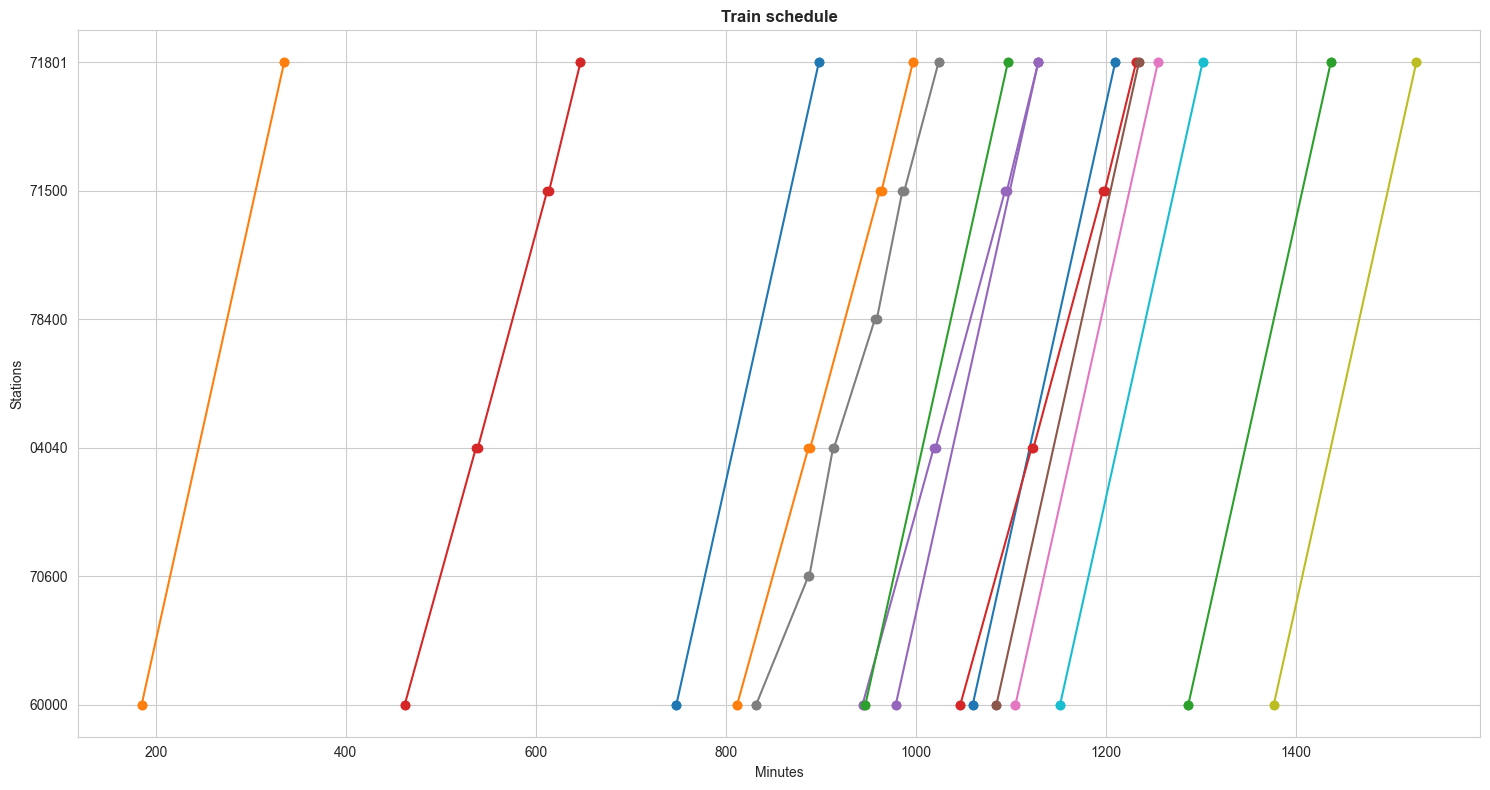

  0%|          | 0/11 [00:00<?, ?it/s]

,Run,Revenue,Execution Time (s.),Scheduled Trains,Delta DT (min.),Delta TT (min.)
7,8.0,2776.187604,1.014587,15.0,46.0,18.0
9,10.0,2729.730057,1.045759,14.0,23.0,9.0
3,4.0,2728.588013,1.012208,15.0,34.0,45.0
5,6.0,2653.733161,1.023248,14.0,21.0,40.0
6,7.0,2644.998941,1.033719,14.0,33.0,32.0
8,9.0,2629.387002,1.024588,14.0,16.0,38.0
2,3.0,2588.844194,1.019871,14.0,24.0,45.0
10,11.0,2531.900384,1.039444,13.0,13.0,44.0
1,2.0,2528.671160,1.042494,13.0,21.0,29.0
4,5.0,2515.157877,1.033584,13.0,6.0,44.0


Global GSA status:
	Total execution time: 11.4021 s.
	Execution Time (by run) - Mean: 1.0366 s. - Std: 0.0276 s.
	Revenue - Mean: 2618.9536 - Std: 98.6767
	Scheduled Trains - Mean: 14.0 - Std: 1.0
	Median solution: Run 1
	Max Revenue: 2959.0 - WARNING!: Scheduling all services could not be feasible


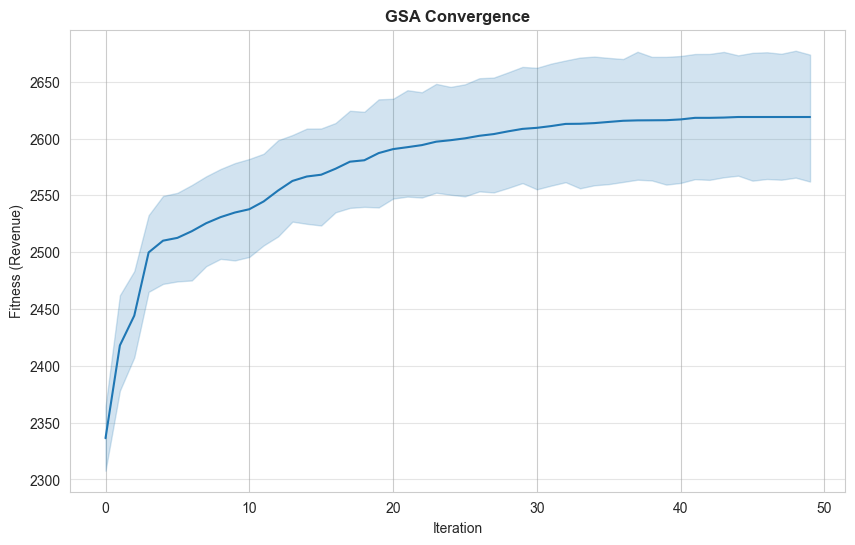

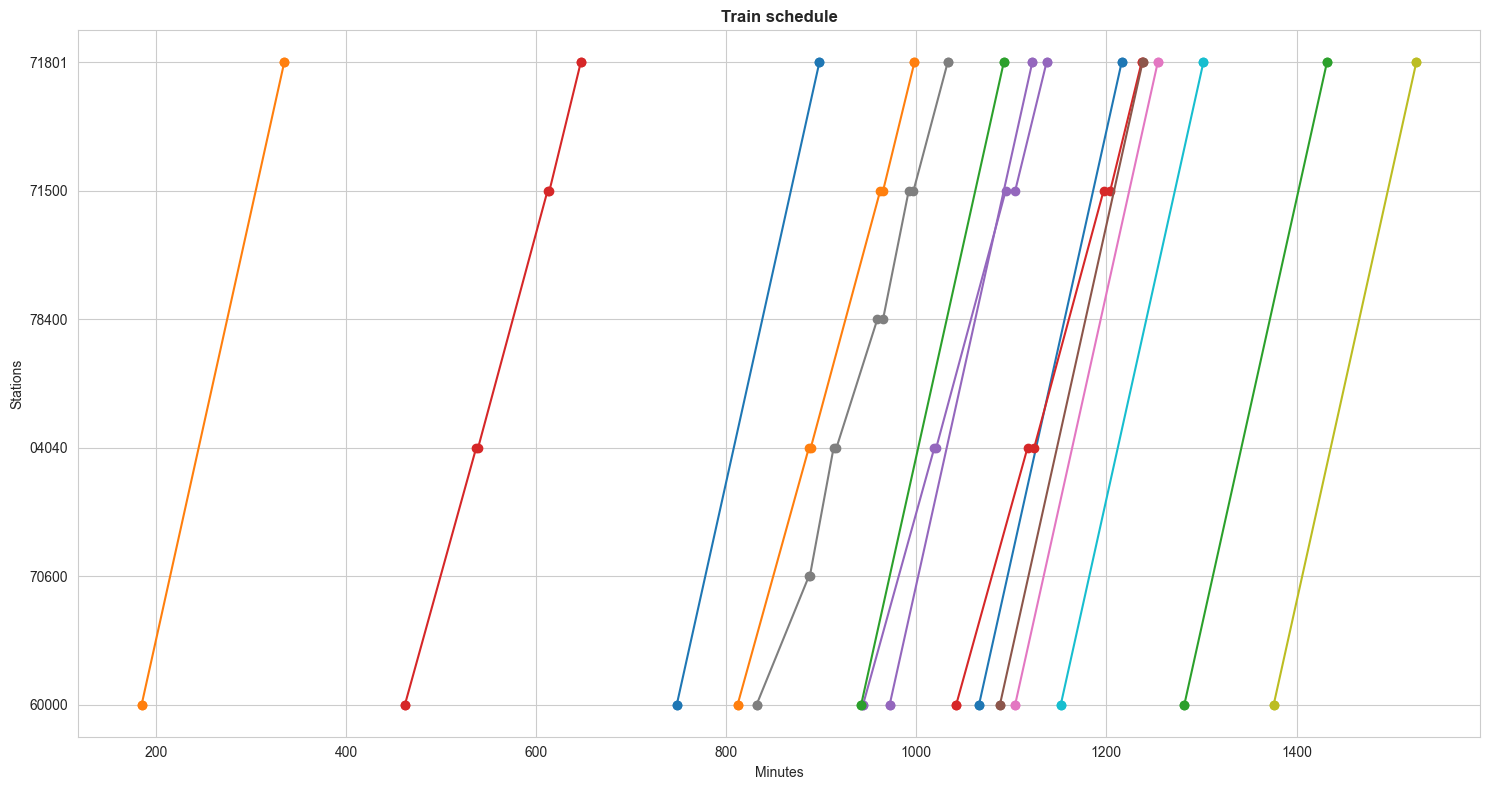

Data from demand plot: 
	Status: User bought a service which was not the one with the best utility. - Passengers: 3669
	Status: User found  any service that met his needs but couldn't purchase. - Passengers: 3462
	Status: User bought the ticket with best utility. - Passengers: 914
	Status: User didn't find any ticket that met his needs. - Passengers: 0

Data from pie chart: 
	Total tickets sold:  4583
	Percentage of tickets sold by seat type: 
		Seat: Premium - Passengers: 800 - Percentage: 17.46 %
		Seat: Turista - Passengers: 3483 - Percentage: 76.0 %
		Seat: Turista Plus - Passengers: 300 - Percentage: 6.55 %

Data from plot tickets sold by purchase day: 
	Total tickets sold:  4583
	Tickets sold by purchase date and seat type: 
		Date: 2023-06-11
			Seat: Turista - Number of tickets sold: 148
		Date: 2023-06-12
			Seat: Premium - Number of tickets sold: 23
			Seat: Turista - Number of tickets sold: 119
		Date: 2023-06-13
			Seat: Premium - Number of tickets sold: 27
			Seat: Turista

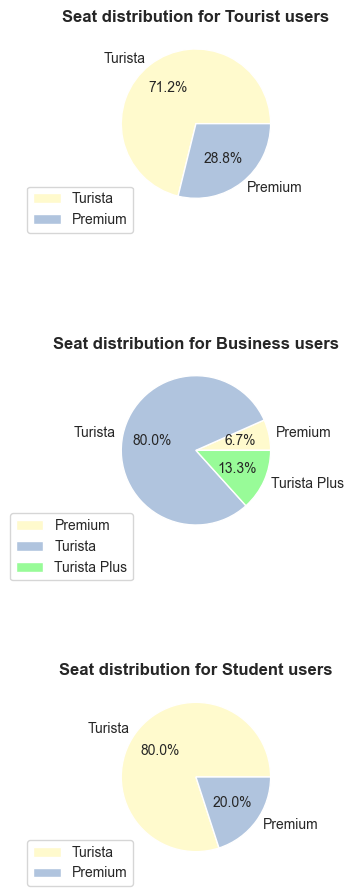

In [5]:
rmd = RailwayMarketDynamics(supply_config_path=supply_config_path,
                            demand_config_path=demand_config_path,
                            generator_config_path=generator_config_path,
                            generator_save_path=generator_save_path,
                            seed = 21)

services = rmd.run(gsa_supply_save_path=supply_save_path,
                    robin_save_path=f'{robin_save_path}output.yml',
                    gsa_population=20,
                    gsa_iters=50,
                    gsa_runs=11,
                    gsa_chaotic=True,
                    gsa_verbosity=False)

In [ ]:
def detect_interference(schedule_data, safety_gap):
    train_ids = list(schedule_data.keys())
    num_trains = len(train_ids)
    interference_matrix = np.zeros((num_trains, num_trains), dtype=bool)

    # Comparar cada tren con todos los demás trenes
    for i, train_id1 in enumerate(train_ids):
        for j in range(i+1, num_trains):
            train_id2 = train_ids[j]
            for station in schedule_data[train_id1]:
                if station in schedule_data[train_id2]:
                    # Comprobar si los tiempos se superponen considerando el gap de seguridad
                    departure1 = schedule_data[train_id1][station][1] + safety_gap
                    arrival2 = schedule_data[train_id2][station][0]
                    departure2 = schedule_data[train_id2][station][1] + safety_gap
                    arrival1 = schedule_data[train_id1][station][0]
                    if arrival1 < departure2 or arrival2 < departure1:
                        interference_matrix[i][j] = True
                        interference_matrix[j][i] = True
                        break  # No necesitamos más comprobaciones si ya hay interferencia
    return interference_matrix



In [10]:
from robin.demand.entities import Demand

demand = Demand.from_yaml('../configs/demand/demand.yml')

In [11]:
passengers = demand.generate_passengers()

In [12]:
p = passengers[0]

In [19]:
values = [float(rule.split(' ')[-1]) for r, rule in p.user_pattern._rules.items()]
values

[30.0, 40.0, 30.0]

In [44]:
import random

def update_rules(values: list, max_change: int=2):
    for _ in range(len(values)):
        # Set two random indexes
        idx1, idx2 = random.sample(range(len(values)), 2)
        
        # Calculate the amount of change
        cambio = np.round(random.uniform(1, min(max_change, values[idx1], values[idx2])))
        
        # Adjust the values
        values[idx1] -= cambio
        values[idx2] += cambio    
    return values

# Original
original = [30.0, 40.0, 30.0]

updated = update_rules(original.copy())
updated

[29.0, 37.0, 34.0]

100.0


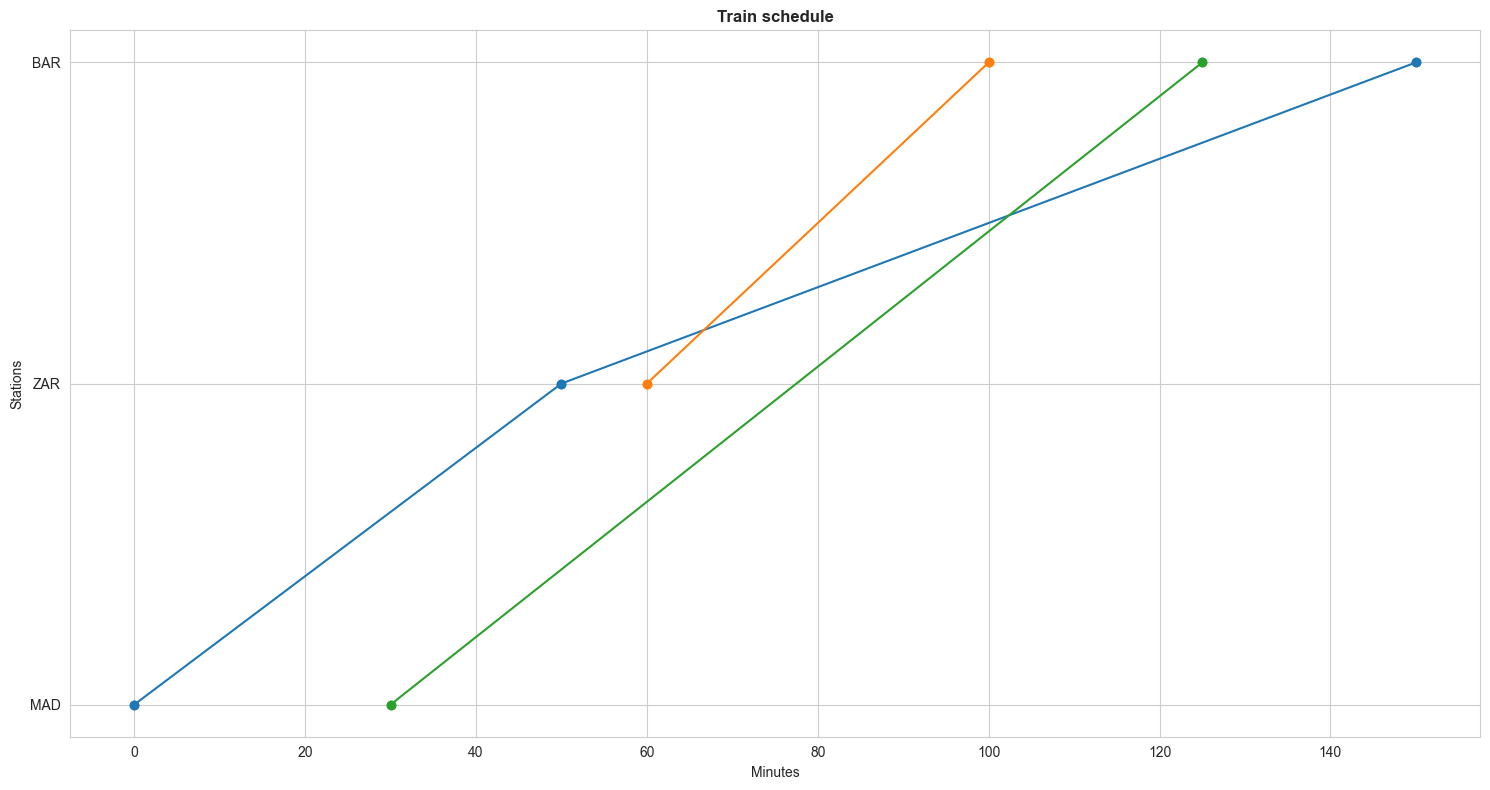

In [67]:
from benchmarks.utils import TrainSchedulePlotter

schedule = {0: {'MAD': (0, 0), 'ZAR': (50, 50), 'BAR': (150, 150)},
            1: {'ZAR': (60, 60), 'BAR': (100, 100)},
            2: {'MAD': (30, 30), 'BAR': (125, 125)}}

schedule_plotter = TrainSchedulePlotter(schedule)
schedule_plotter.plot()

In [68]:
def infer_station_order(schedule):
    trips = [list(trip.keys()) for trip in schedule.values()]
    line = trips.pop(trips.index(max(trips, key=len)))

    for trip in trips:
        for i, s in enumerate(trip):
            if s not in line:
                line.insert(line.index(trip[i + 1]), s)

    return {sta: i for i, sta in enumerate(line)}

line_stations = infer_station_order(schedule)
line_stations

{'MAD': 0, 'ZAR': 1, 'BAR': 2}

In [69]:
schedule_matrix = []
for service in schedule:
    row = []
    for station, _ in line_stations.items():
        if station not in schedule[service]:
            row.append(np.nan)
        else:
            row.append(schedule[service][station])
    schedule_matrix.append(row)
            
print(schedule_matrix)

[[(0, 0), (50, 50), (150, 150)], [nan, (60, 60), (100, 100)], [(30, 30), nan, (125, 125)]]


In [70]:
from shapely.geometry import LineString

def get_closest_station(station, line_stations, other_service_stations):
    station_idx = line_stations[station]
    closest_station = None
    min_distance = float('inf')
    for other_station in other_service_stations:
        other_station_idx = line_stations[other_station]
        distance = abs(station_idx - other_station_idx)
        if distance < min_distance:
            min_distance = distance
            closest_station = other_station
    return closest_station

conflict_matrix = np.zeros((len(schedule), len(schedule)), dtype=np.bool_)


for i, service in enumerate(schedule):
    print(f"Service {service}")
    service_stations = tuple(schedule[service].keys())
    for k, station in enumerate(service_stations):
        if k == len(service_stations) - 1:
            break
        
        segment = LineString([(schedule[service][station][1], line_stations[station]),
                             (schedule[service][service_stations[k + 1]][0], line_stations[service_stations[k + 1]])])
        for j, other_service in enumerate(tuple(schedule.keys())[i+1:]):
            if other_service == service:
                continue
            other_service_stations = tuple(schedule[other_service].keys())
            other_service_init = station if station in other_service_stations else get_closest_station(station,
                                                                                                       line_stations, other_service_stations)
            
            if other_service_init == other_service_stations[-1] or line_stations[other_service_init] >= line_stations[service_stations[k + 1]]:
                continue
             
            other_service_end = other_service_stations[other_service_stations.index(other_service_init) + 1]
            other_segment = LineString([(schedule[other_service][other_service_init][1], line_stations[other_service_init]),
                                        (schedule[other_service][other_service_end][0], line_stations[other_service_end])])
            
            int_point = segment.intersection(other_segment)
            if int_point:
                conflict_matrix[i][j] = True
                conflict_matrix[j][i] = True
                print(f"Conflict between {service} and {other_service} at {int_point}")
                
print(conflict_matrix)

Service 0
Conflict between 0 and 1 at POINT (66.66666666666667 1.1666666666666667)
Conflict between 0 and 2 at POINT (102.38095238095238 1.5238095238095237)
Service 1
Service 2
[[ True  True False]
 [ True False False]
 [False False False]]


In [27]:
L1 = line([0,1], [2,3])
L2 = line([2,3], [0,4])

R = intersection(L1, L2)
if R:
    print("Intersection detected:", R)
else:
    print("No single intersection point detected")

Intersection detected: (2.0, 3.0)
